# Simulating Clifford randomized benchmarking using implicit models

This tutorial demonstrates shows how to simulate Clifford RB sequences using $n$-qubit "implicit" models which build $n$-qubit process matrices from smaller building blocks.  This restricts the noise allowed in the $n$-qubit model; in this tutorial we take $n=3$ and use a `LocalNoiseModel`.

In [1]:
from __future__ import print_function #python 2 & 3 compatibility

import pygsti
from pygsti.extras import rb
import numpy as np

Welcome to pygsti version 0.9.7!
There have been some major changes between this version and 0.9.6 - ones that break backward compatibility.  If you're trying to run an old script and nothing works, DON'T PANIC; we've tried to make the transition easy.  More often then not, you can just run `pyGSTi/scripts/upgrade2v0.9.7.py` on your old script or notebook files and you'll be up and running again.  For more information, see the pyGSTi FAQ.ipynb.

If this warning annoys you run:
  `export PYGSTI_BACKCOMPAT_WARNING=0` from the command line or
  `import os; os.environ['PYGSTI_BACKCOMPAT_WARNING'] = '0'` in a script or
     notebook *before* importing pygsti and the the madness will stop.


## Get some CRB circuits

First, we follow the [Clifford RB](../CliffordRB.ipynb) tutorial to generate a set of sequences.  If you want to perform Direct RB instead, just replace this cell with the contents of the [Direct RB](../DirectRB.ipynb) tutorial up until the point where it creates `circuitlist`:

In [2]:
#Specify the device to be benchmarked - in this case 2 qubits
nQubits = 3
qubit_labels = list(range(nQubits)) 
gate_names = ['Gx', 'Gy','Gcphase'] 
availability = {'Gcphase':[(i,i+1) for i in range(nQubits-1)]}
pspec = pygsti.obj.ProcessorSpec(nQubits, gate_names, availability=availability, 
                                 qubit_labels=qubit_labels)

#Specify RB parameters (k = number of repetitions at each length)
lengths = [0,1,2,4,8,16]
k = 10
subsetQs = qubit_labels
randomizeout = False # ==> all circuits have the *same* ideal outcome (the all-zeros bitstring)

#Generate clifford RB circuits
exp_dict = rb.sample.clifford_rb_experiment(pspec, lengths, k, subsetQs=subsetQs, randomizeout=randomizeout)

#Collect all the circuits into one list:
circuitlist = [exp_dict['circuits'][m,i] for m in lengths for i in range(k)]

- Sampling 10 circuits at CRB length 0 (1 of 6 lengths)
  - Number of circuits sampled = 1,2,3,4,5,6,7,8,9,10,
- Sampling 10 circuits at CRB length 1 (2 of 6 lengths)
  - Number of circuits sampled = 1,2,3,4,5,6,7,8,9,10,
- Sampling 10 circuits at CRB length 2 (3 of 6 lengths)
  - Number of circuits sampled = 1,2,3,4,5,6,7,8,9,10,
- Sampling 10 circuits at CRB length 4 (4 of 6 lengths)
  - Number of circuits sampled = 1,2,3,4,5,6,7,8,9,10,
- Sampling 10 circuits at CRB length 8 (5 of 6 lengths)
  - Number of circuits sampled = 1,2,3,4,5,6,7,8,9,10,
- Sampling 10 circuits at CRB length 16 (6 of 6 lengths)
  - Number of circuits sampled = 1,2,3,4,5,6,7,8,9,10,


## Create a model to simulate these circuits
Now we need to create a model that can simulate circuits like this. The RB circuits use pyGSTi's "multi-qubit" conventions, which mean:
1. RB circuits use our "multi-qubit" gate naming, so you have gates like `Gx:0` and `Gcphase:0:1`.
2. RB circuits do gates in parallel (this only matters for >1 qubits), so you have layers like `[Gy:0Gy:1]`

"Implicit" models in pyGSTi (see the [implicit model tutorial](../../objects/ImplicitModel.ipynb)) are designed to efficiently describe multi-qubit processors.  There are numerous ways of constructing implicit models, all of which can simulate the type of circuits described above.  Here we'll demonstrate the simplest type: a "local noise model" (class `LocalNoiseModel`) where the noise on a gate can only act on that gate's target qubits - so, for instance, 1-qubit gates are still given by 1-qubit operators, not $n$-qubit ones.

The construction of a local noise model follows the same pattern as building the `ProcessorSpec` above (in fact, `pspec.models['target']` *is* essentially the same model we build below except it was built with the default `parmeterization="static"` argument.

In [3]:
myModel = pygsti.obj.LocalNoiseModel.build_from_parameterization(nQubits, gate_names,
                                                                 availability=availability, 
                                                                 qubit_labels=qubit_labels,
                                                                 parameterization="full")

Setting `parameterization="full"` is important, as it lets us assign arbitrary numpy arrays to gates as we'll show below.  If you need to use other gates that aren't built into pyGSTi, you can use the `nonstd_gate_unitaries`
argument of `build_from_parameterization` (see the docstring).

The `build_from_parameterization` function creates a model with ideal (perfect) gates.  We'll now create a 1-qubit depolarization superoperator, and a corresponding 2-qubit one (just the tensor product of two 1-qubit ones) to add some simple noise.  

In [4]:
depol1Q = np.array([[1, 0,   0, 0],
                    [0, 0.99, 0, 0],
                    [0, 0, 0.99, 0],
                    [0, 0, 0, 0.99]], 'd') # 1-qubit depolarizing operator
depol2Q = np.kron(depol1Q,depol1Q)

As detailed in the [implicit model tutorial](../../objects/ImplicitModel.ipynb), the gate operations of a `LocalNoiseModel` are held in its `.operation_blks['gates']` dictionary.  We'll alter these by assigning new process matrices to each gate.  In this case, it will be just a depolarized version of the original gate.

In [5]:
myModel.operation_blks['gates']["Gx"] = np.dot(depol1Q, myModel.operation_blks['gates']["Gx"])
myModel.operation_blks['gates']["Gy"] = np.dot(depol1Q, myModel.operation_blks['gates']["Gy"])  
myModel.operation_blks['gates']["Gcphase"] = np.dot(depol2Q, myModel.operation_blks['gates']["Gcphase"])

Here's what the gates look like now:

In [6]:
print(myModel.operation_blks['gates']["Gx"])
print(myModel.operation_blks['gates']["Gy"])
print(myModel.operation_blks['gates']["Gcphase"])

FullDenseOp with shape (4, 4)
 1.00   0   0   0
   0 0.99   0   0
   0   0   0-0.99
   0   0 0.99   0

FullDenseOp with shape (4, 4)
 1.00   0   0   0
   0   0   0 0.99
   0   0 0.99   0
   0-0.99   0   0

FullDenseOp with shape (16, 16)
 1.00   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0 0.99   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0 0.99   0
   0   0   0 0.99   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0 0.99   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0 0.98   0   0   0   0   0
   0   0   0   0   0   0   0   0   0-0.98   0   0   0   0   0   0
   0   0   0   0 0.98   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0 0.99   0   0   0   0
   0   0   0   0   0   0-0.98   0   0   0   0   0   0   0   0   0
   0   0   0   0   0 0.98   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0 0.9

Now that our `Model` object is set to go, generating simulated data is easy:

In [7]:
ds = pygsti.construction.generate_fake_data(myModel, circuitlist, 100, seed=1234)

## Running RB on the simulated `DataSet`
To run an RB analysis, we need to collect the "success" outcome counts for each circuit.  We just build up parallel lists as show below, using the `'idealout'` key (even though it's always the same in this case) of `exp_dict` to determine what outcome we were supposed to get.  These parallel lists can be used to initialize a `RBSummaryDataSet` object.

In [8]:
lengthslist = []
counts = []
scounts = []
cdepths = []
c2Qgatecnts = []

for m in lengths:
    for i in range(k):
        c = exp_dict['circuits'][m,i]
        ideal_outcome = ''.join(map(str,exp_dict['idealout'][m,i]))
        datarow = ds[c]
        lengthslist.append(m)
        counts.append(datarow.total)
        scounts.append(datarow[ideal_outcome])
        cdepths.append(c.depth())
        c2Qgatecnts.append(c.twoQgate_count())

#Then we can create a RBSummaryDataset object, which contains all the info needed to perform 
# our standard RB analyses:
data = rb.results.RBSummaryDataset(nQubits, lengthslist, success_counts=scounts, total_counts=counts,
                             circuit_depths=cdepths, circuit_twoQgate_counts=c2Qgatecnts)

One we have a `RBSummaryDataSet`, we can just follow the final steps of the [RB analysis tutorial](../RBAnalysis.ipynb) to perform a standard RB analysis and plot the results.

In [9]:
#Do a standard RB analysis
rbresults = rb.analysis.std_practice_analysis(data)

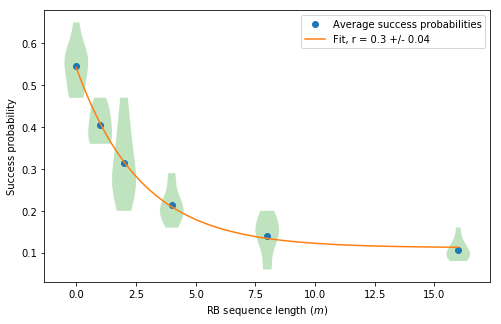

In [10]:
#Plot some stuff, etc - see the RBAnalysis.ipynb for more on this.
%matplotlib inline
rbresults.plot()